In [1]:
import numpy as np
from astropy.io import fits
import astropy.units as u
import astropy.constants as const
import matplotlib.pyplot as plt
from matplotlib.cm import register_cmap
import astropy.units as u
from astropy.wcs import WCS
from astropy.visualization import ImageNormalize, ZScaleInterval
import tensorflow as tf
import skimage.measure as skmeas
from os import listdir
import paramiko
from skimage.util.shape import view_as_windows
import os
import gc

## Load in cubes

In [184]:
[i for i in listdir("../data/training/Target")if ".fits" in i]

['mask_1245mosC.fits', 'mask_1245mosB.fits']

In [2]:
cube_hdulist = fits.open("../data/training/Input/noisefree_1245mosC.fits")
cube_data = cube_hdulist[0].data
cube_hdulist.close()

maskcube_hdulist = fits.open("../data/training/Target/mask_1245mosC.fits")
maskcube_data = maskcube_hdulist[0].data
maskcube_hdulist.close()

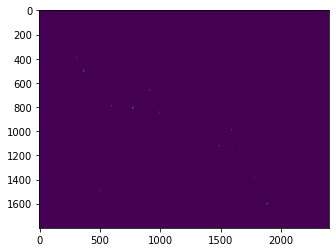

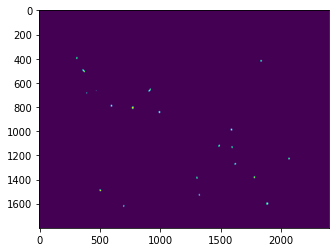

In [5]:
plt.imshow(cube_data[300, :, :])
plt.show()
plt.imshow(maskcube_data[300, :, :])
plt.show()

# Sanity check for sliding window

In [ ]:
import nibabel as nib
n1_img = nib.load('../nsM00587_0002.hdr').get_fdata()
n1_img.shape

In [ ]:
from skimage.util.shape import view_as_windows

kernel=(78, 94, 34)
stride=(78, 94, 34)
subvols = view_as_windows(n1_img, kernel, stride)
x,y,z = subvols.shape[:3]
sx, sy, sz = kernel
subvols = tf.reshape(subvols,[x*y*z,sx,sy,sz])
subvols.shape

In [ ]:
for i in range(1, len(subvols)):
    plt.imshow(subvols[i][:, :, 0])
    plt.show()

## Test sliding window

In [354]:
cube_hdulist = fits.open("../Target/mask_0.fits")
cube_data = cube_hdulist[0].data
cube_hdulist.close()
cube_data.shape

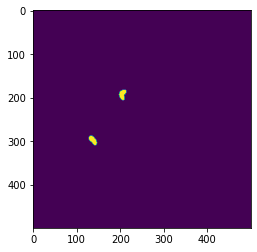

In [89]:
reshaped = np.moveaxis(maskcube_data[:300, :500, :500], 0, 2)
plt.imshow(reshaped[:, :, 200])

In [20]:
from skimage.util.shape import view_as_windows

kernel=(128, 128, 64)
stride=np.array(kernel) - np.array((15, 20, 20))
subvols = view_as_windows(reshaped, kernel, stride)
x,y,z = subvols.shape[:3]
sx, sy, sz = kernel
subvols = tf.reshape(subvols,[x*y*z,sx,sy,sz])
print(len(subvols), subvols[0].shape)

96 (128, 128, 64)


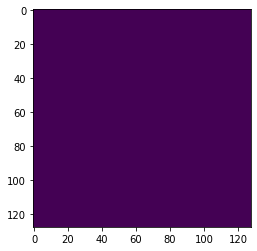

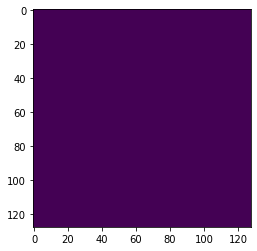

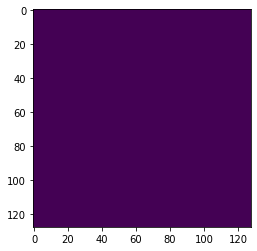

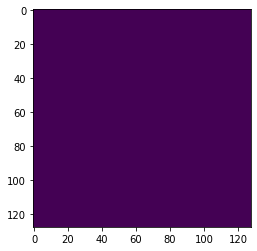

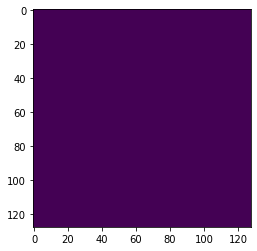

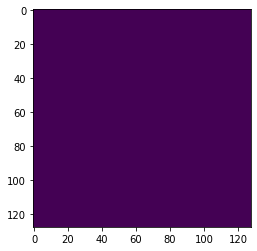

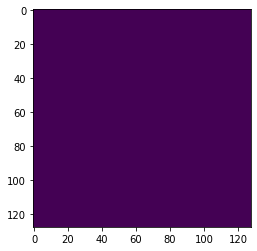

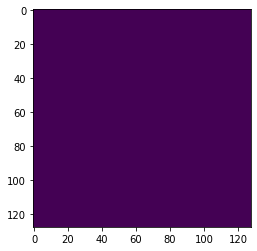

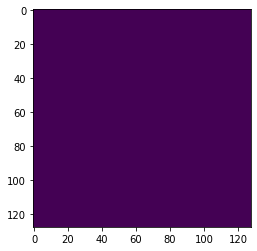

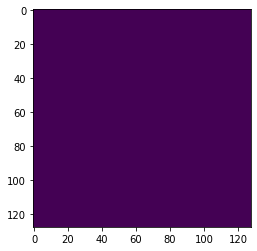

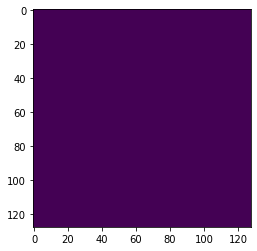

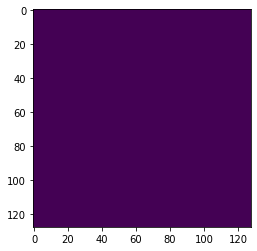

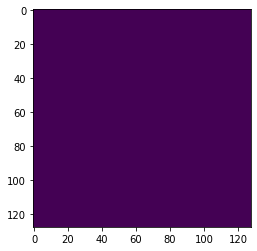

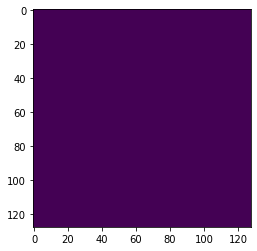

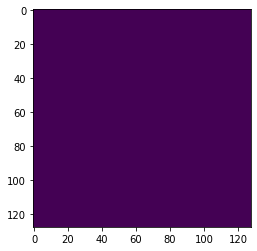

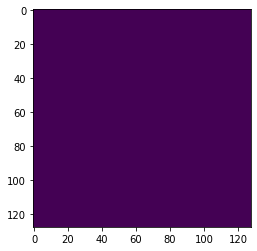

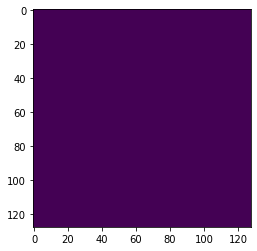

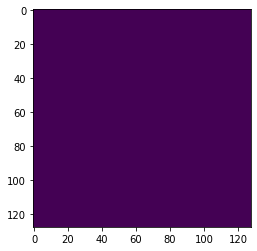

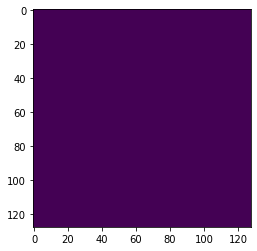

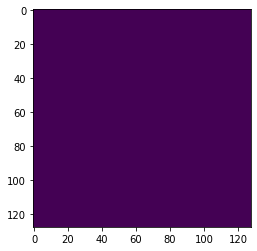

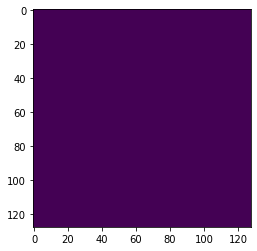

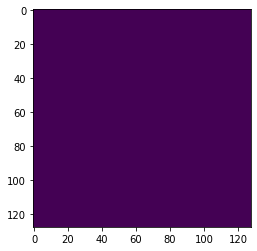

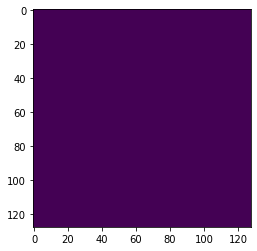

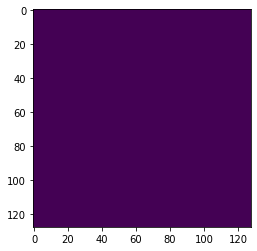

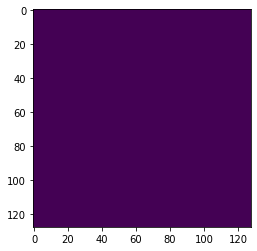

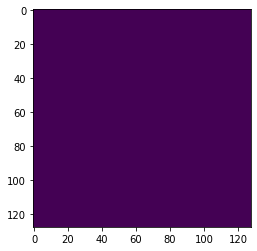

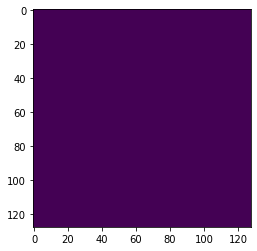

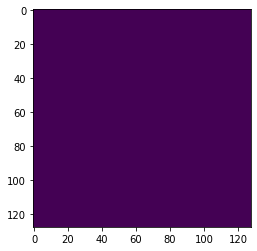

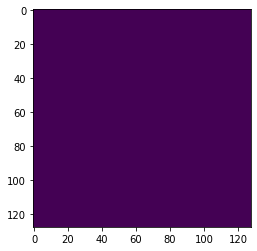

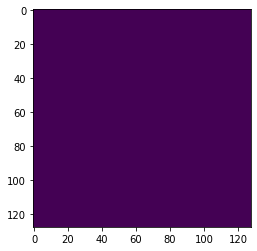

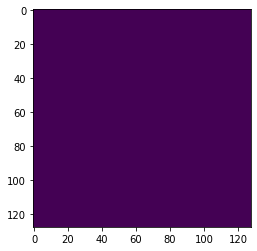

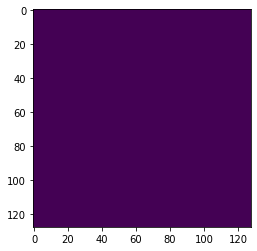

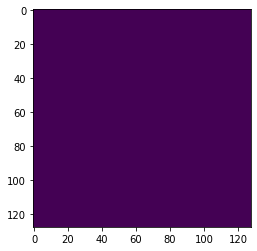

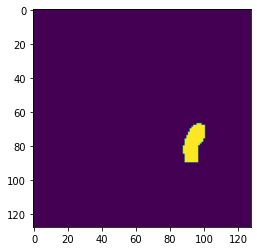

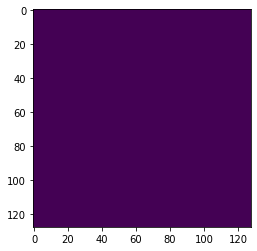

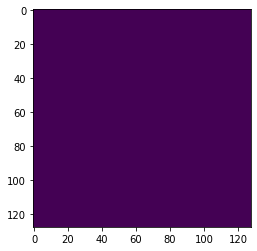

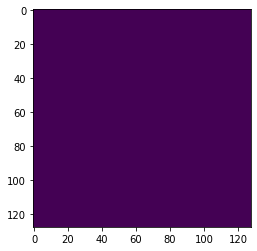

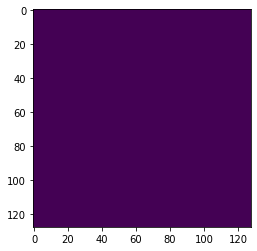

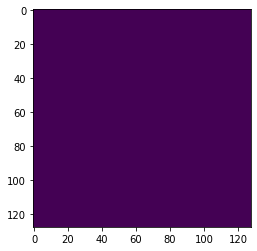

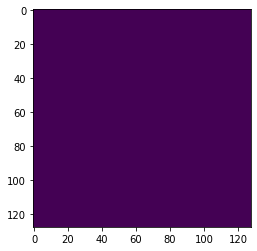

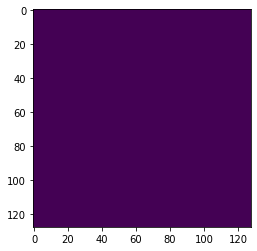

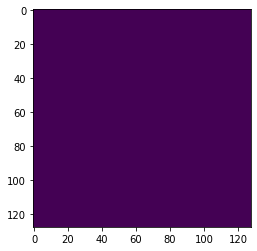

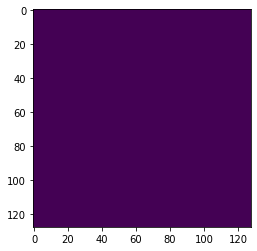

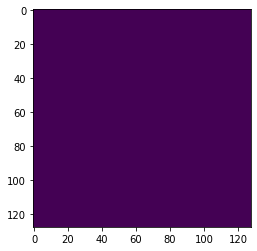

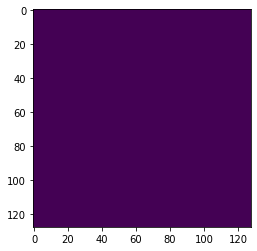

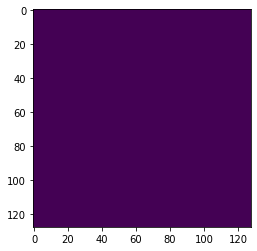

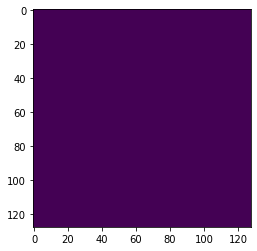

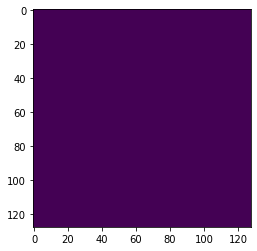

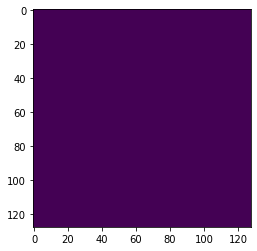

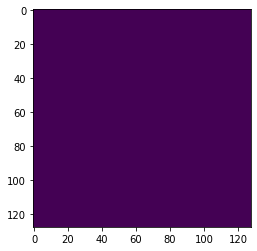

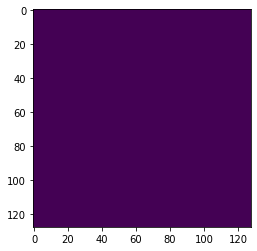

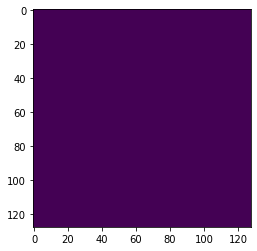

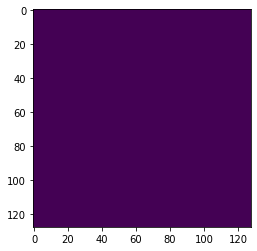

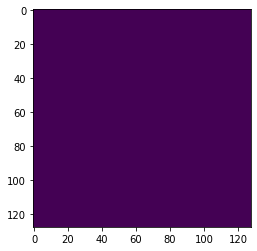

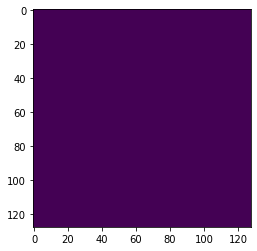

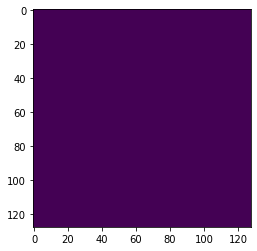

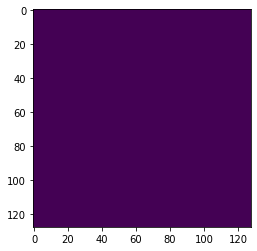

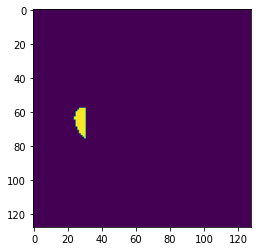

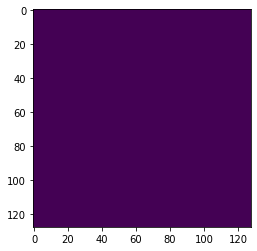

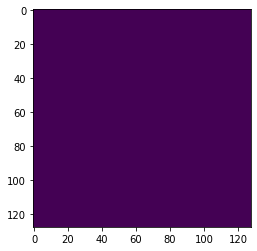

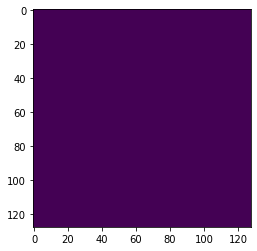

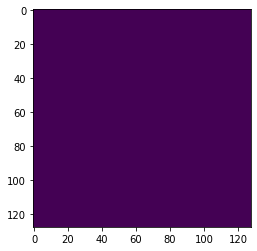

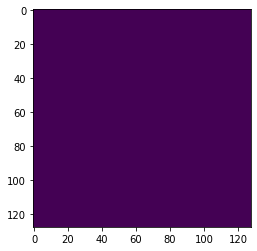

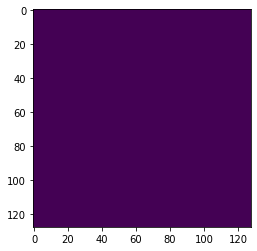

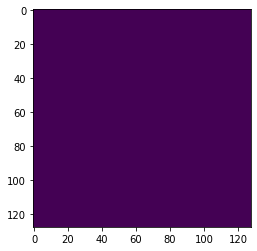

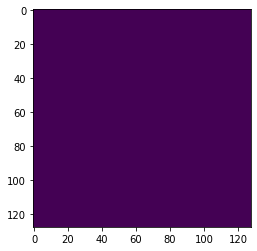

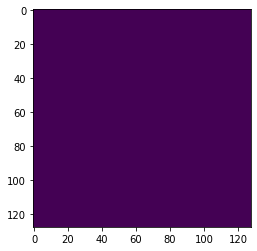

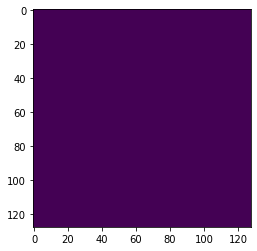

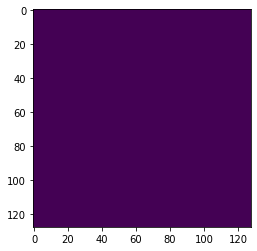

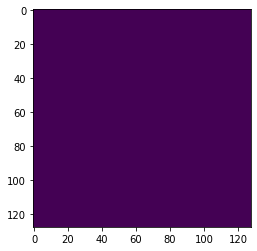

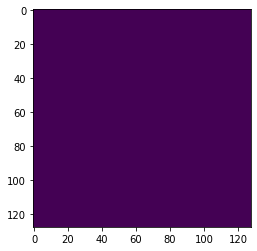

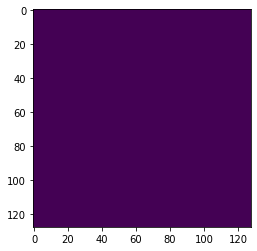

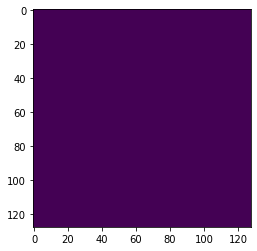

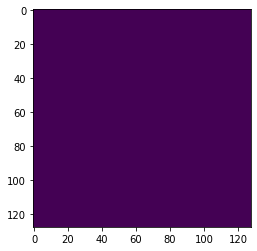

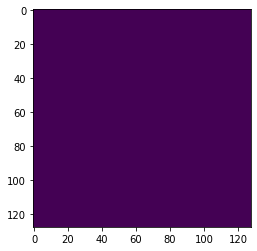

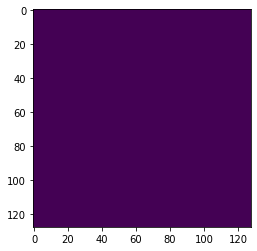

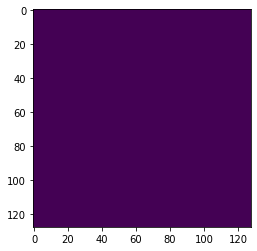

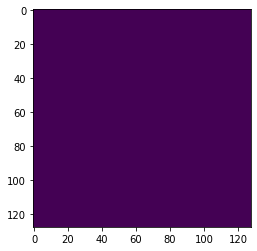

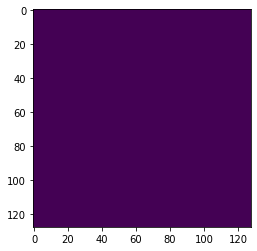

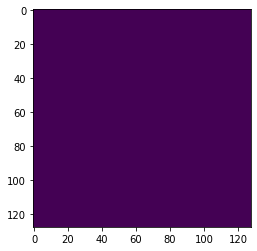

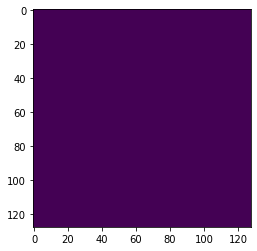

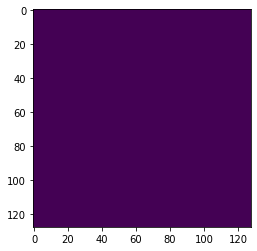

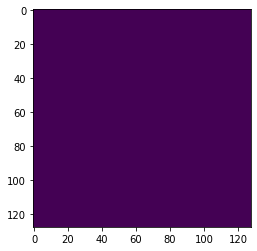

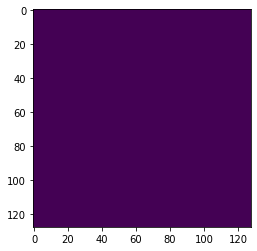

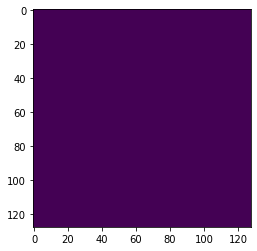

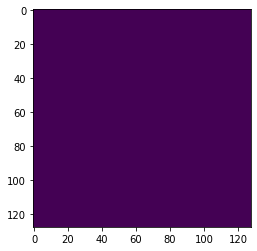

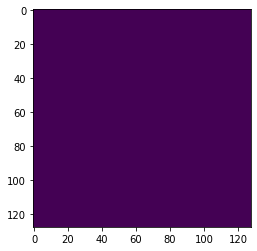

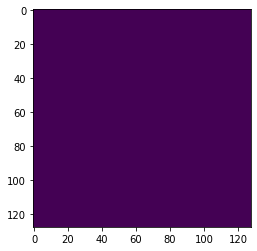

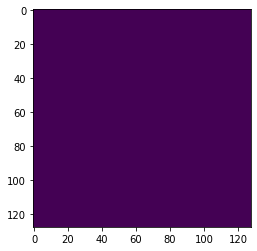

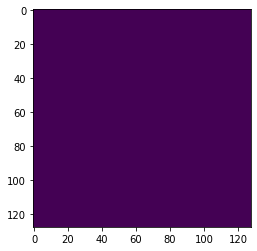

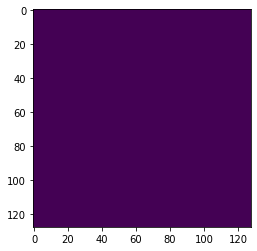

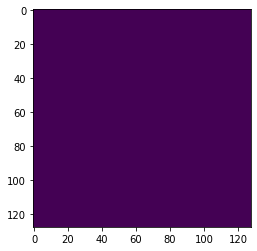

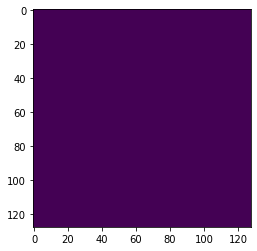

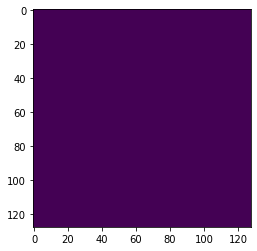

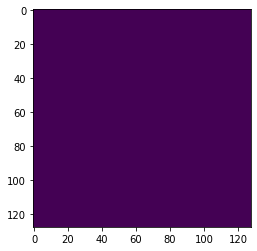

In [21]:
for i in range(1, len(subvols)):
    plt.imshow(subvols[i][:, :, 30])
    plt.show()

## Dimensions of galaxies
- [x] Volume
- [x] Total Flux
- [x] Peak Flux
- [x] Eccentricity
- [x] Flatness

### 1. First test with tiny cube with two galaxies

In [355]:
test_mask = maskcube_data[195:205, :500, :500]
test_subcube = cube_data[195:205, :500, :500]
new_mask = test_mask > 0
object_labels = skmeas.label(new_mask)

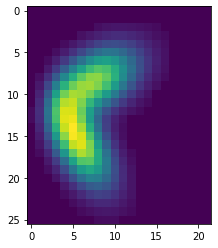

Eccentricity = 1.3186422460924205
Flatness = 1.6586410582123614
Dimensions =  (10, 26, 22)
Volume =  5720
Total Flux =  0.41890385464299473
Peak Flux =  0.004320765342563391


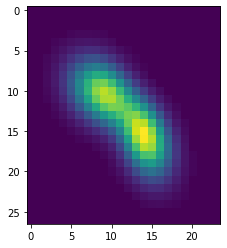

Eccentricity = 1.3855970581368249
Flatness = 1.6686376610259082
Dimensions =  (10, 27, 24)
Volume =  6480
Total Flux =  0.36448865704180206
Peak Flux =  0.0036930414009839294

Percentage of cube =  0.488 %


In [127]:
some_props = skmeas.regionprops(object_labels)
gal_list = []
for i in range(len(some_props)):
    bb = some_props[i].bbox
    where_gal = test_subcube[bb[0]:bb[3], bb[1]:bb[4], bb[2]:bb[5]]
    flux = np.sum(where_gal)
    peak_flux = np.max(np.sum(where_gal, axis=0))
    plt.imshow(test_subcube[int((bb[3] - bb[0])/2), bb[1]:bb[4], bb[2]:bb[5]])
    plt.show()
    gal_list.append(where_gal)
    eigen_vals = some_props[i].inertia_tensor_eigvals
    eccentricity = eigen_vals[0]/eigen_vals[1]
    flatness = eigen_vals[1]/eigen_vals[2]
    galdims = some_props[i].image.shape
    vol = np.prod(galdims)
    print("Eccentricity =", eccentricity)
    print("Flatness =", flatness)
    print("Dimensions = ", galdims)
    print("Volume = ", vol)
    print("Total Flux = ", flux)
    print("Peak Flux = ", peak_flux)

vols = [np.prod(i.image.shape) for i in some_props]    
pixel_percent = np.sum(vols)/np.prod(test_mask.shape)
print()
print("Percentage of cube = ", pixel_percent*100, "%")

### 2. Apply to whole cube

In [9]:
new_mask = maskcube_data > 0
object_labels = skmeas.label(new_mask)

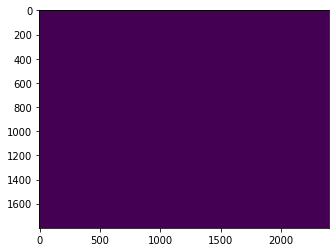

In [10]:
plt.imshow(object_labels[5])

In [11]:
some_props = skmeas.regionprops(object_labels)

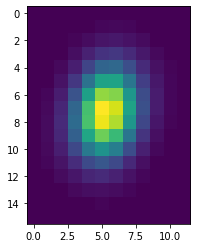

Eccentricity = 1.0563452633241044
Flatness = 5.921171441326793
Dimensions =  (36, 16, 12)
Volume =  6912
Total Flux =  0.04157509620516066
Peak/ Flux =  0.0016133659768092915


In [150]:
i = 0
bb = some_props[i].bbox
where_gal = cube_data[bb[0]:bb[3], bb[1]:bb[4], bb[2]:bb[5]]
flux = np.sum(where_gal)
peak_flux = np.max(np.sum(where_gal, axis=0))
plt.imshow(where_gal[int((bb[3] - bb[0])/2)])
plt.show()
eigen_vals = some_props[i].inertia_tensor_eigvals
eccentricity = eigen_vals[0]/eigen_vals[1]
flatness = eigen_vals[1]/eigen_vals[2]
galdims = some_props[i].image.shape
vol = np.prod(galdims)
print("Eccentricity =", eccentricity)
print("Flatness =", flatness)
print("Dimensions = ", galdims)
print("Volume = ", vol)
print("Total Flux = ", flux)
print("Peak/ Flux = ", peak_flux)

In [161]:
bbs = [gal.bbox for gal in some_props]
tot_fluxes = [np.sum(cube_data[bbs[i][0]:bbs[i][3], bbs[i][1]:bbs[i][4], bbs[i][2]:bbs[i][5]])
     for i in range(len(some_props))]
peak_fluxes = [np.max(np.sum(cube_data[bbs[i][0]:bbs[i][3], bbs[i][1]:bbs[i][4], bbs[i][2]:bbs[i][5]], axis=0))
     for i in range(len(some_props))]
eigen_vals = [gal.inertia_tensor_eigvals for gal in some_props]
eccentricities = [e[0]/e[1] for e in eigen_vals]
flatnesses = [e[1]/e[2] for e in eigen_vals]
galdims = [gal.image.shape for gal in some_props]
vols = [np.prod(gal) for gal in galdims]
pixel_percent = np.sum(vols)/np.prod(cube_data.shape)

   
print()
print("Percentage of cube = ", pixel_percent*100, "%")


Percentage of cube =  0.15552942513065213 %


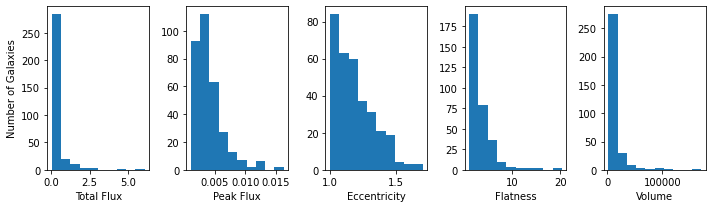

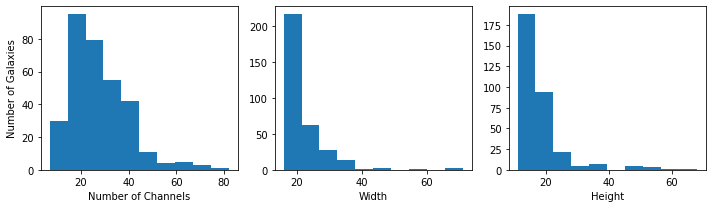

In [168]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(10,3))
ax1.hist(tot_fluxes)
ax2.hist(peak_fluxes)
ax3.hist(eccentricities)
ax4.hist(flatnesses)
ax5.hist(vols)
ax1.set_ylabel("Number of Galaxies")
ax1.set_xlabel("Total Flux")
ax2.set_xlabel("Peak Flux")
ax3.set_xlabel("Eccentricity")
ax4.set_xlabel("Flatness")
ax5.set_xlabel("Volume")
fig.tight_layout()
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,3))
ax1.hist([i[0] for i in galdims])
ax2.hist([i[1] for i in galdims])
ax3.hist([i[2] for i in galdims])
ax1.set_xlabel("Number of Channels")
ax2.set_xlabel("Width")
ax3.set_xlabel("Height")
ax1.set_ylabel("Number of Galaxies")
fig.tight_layout()
plt.show()

## Summary results for all 14 cubes (ran with seperate script)

In [5]:
import pickle
with open("../data_generators/cube_summaries/eccentricity.txt", "rb") as fp:
    eccentricity = pickle.load(fp)
with open("../data_generators/cube_summaries/flatness.txt", "rb") as fp:
    flatness = pickle.load(fp)
with open("../data_generators/cube_summaries/vol.txt", "rb") as fp:
    vol = pickle.load(fp)
with open("../data_generators/cube_summaries/galdim.txt", "rb") as fp:
    galdim = pickle.load(fp)
with open("../data_generators/cube_summaries/tot_flux.txt", "rb") as fp:
    tot_flux = pickle.load(fp)
with open("../data_generators/cube_summaries/peak_flux.txt", "rb") as fp:
    peak_flux = pickle.load(fp)
with open("../data_generators/cube_summaries/voxel_percents.txt", "rb") as fp:
    pixel_percents = pickle.load(fp)

In [6]:
freq_dict = {"mask_1245mosB.fits": [1401252439.970,1425092772.001],
"mask_1245mosC.fits": [1381037599.970,1404877932.001],
"mask_1245mosD.fits": [1360822751.970,1384663084.001],
"mask_1245mosE.fits": [1340607911.970,1364448244.001],
"mask_1245mosF.fits": [1320393067.970,1344233400.001],
"mask_1245mosG.fits": [1300178221.970,1324018554.001],
"mask_1245mosH.fits": [1279963378.910,1303803710.941],
"mask_1353mosB.fits": [1401179199.970,1425019532.001],
"mask_1353mosC.fits": [1380964351.970,1404804684.001],
"mask_1353mosD.fits": [1360749511.970,1384589844.001],
"mask_1353mosE.fits": [1340534667.970,1364375000.001],
"mask_1353mosF.fits": [1320319823.970,1344160156.001],
"mask_1353mosG.fits": [1300104979.970,1323945312.001],
"mask_1353mosH.fits": [1279890136.720,1303730468.751]}

In [7]:
import pandas as pd

freq_axis_1353 = [freq_dict[i[0]] for i in eccentricity if "mask_1353" in i[0]]
freq_axis_1245 = [freq_dict[i[0]] for i in eccentricity if "mask_1245" in i[0]]
freq_ticks = [float(i[0]) for i in freq_axis_1353]
mask_1353_idx = [idx for idx, element in enumerate(eccentricity) if "mask_1353" in element[0]]
mask_1245_idx = [idx for idx, element in enumerate(eccentricity) if "mask_1245" in element[0]]

df_1353 = pd.DataFrame(freq_axis_1353, columns=[["freq_1", "freq_2"]])
df_1353.columns = df_1353.columns.map(''.join)
df_1353['freq_labels'] = np.round(df_1353['freq_1']*1e-9, 2).astype(str) + "-" + np.round(df_1353['freq_2']*1e-9, 2).astype(str)
df_1353["mean_eccentricity"] = [np.mean(i[1:]) for i in eccentricity if "mask_1353" in i[0]]
df_1353["mean_flatness"] = [np.mean(i[1:]) for i in flatness if "mask_1353" in i[0]]
df_1353["mean_vol"] = [np.mean(i[1:]) for i in vol if "mask_1353" in i[0]]
df_1353["mean_peak_flux"] = [np.mean(i[1:]) for i in peak_flux if "mask_1353" in i[0]]
df_1353["mean_tot_flux"] = [np.mean(i[1:]) for i in tot_flux if "mask_1353" in i[0]]
df_1353["pixel_percents"] = [i[1]*100 for i in pixel_percents if "mask_1353" in i[0]]
df_1353["num_gal"] = [len(i[1:])for i in eccentricity if "mask_1353" in i[0]]
df_1353["mean_gal_dim0"] = [np.mean([dim[0] for dim in galdim[i]]) for i in mask_1353_idx]
df_1353["mean_gal_dim1"] = [np.mean([dim[1] for dim in galdim[i]]) for i in mask_1353_idx]
df_1353["mean_gal_dim2"] = [np.mean([dim[2] for dim in galdim[i]]) for i in mask_1353_idx]
df_1353 = df_1353.sort_values('freq_1')

df_1245 = pd.DataFrame(freq_axis_1245, columns=[["freq_1", "freq_2"]])
df_1245.columns = df_1245.columns.map(''.join)
df_1245['freq_labels'] = np.round(df_1245['freq_1']*1e-9, 2).astype(str) + "-" + np.round(df_1245['freq_2']*1e-9, 2).astype(str)
df_1245["mean_eccentricity"] = [np.mean(i[1:]) for i in eccentricity if "mask_1245" in i[0]]
df_1245["mean_flatness"] = [np.mean(i[1:]) for i in flatness if "mask_1245" in i[0]]
df_1245["mean_vol"] = [np.mean(i[1:]) for i in vol if "mask_1245" in i[0]]
df_1245["mean_peak_flux"] = [np.mean(i[1:]) for i in peak_flux if "mask_1245" in i[0]]
df_1245["mean_tot_flux"] = [np.mean(i[1:]) for i in tot_flux if "mask_1245" in i[0]]
df_1245["pixel_percents"] = [i[1]*100 for i in pixel_percents if "mask_1245" in i[0]]
df_1245["num_gal"] = [len(i[1:])for i in eccentricity if "mask_1245" in i[0]]
df_1245["mean_gal_dim0"] = [np.mean([dim[0] for dim in galdim[i]]) for i in mask_1245_idx]
df_1245["mean_gal_dim1"] = [np.mean([dim[1] for dim in galdim[i]]) for i in mask_1245_idx]
df_1245["mean_gal_dim2"] = [np.mean([dim[2] for dim in galdim[i]]) for i in mask_1245_idx]
df_1245 = df_1245.sort_values('freq_1')

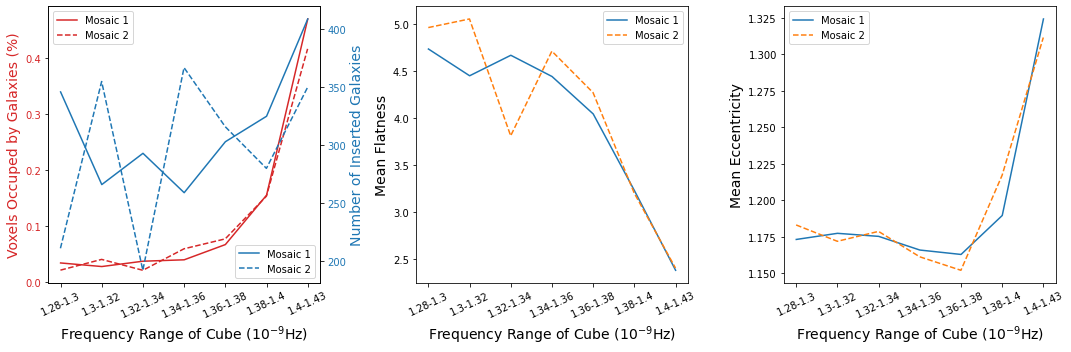

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

color = 'tab:red'
ax1.set_xlabel(r"Frequency Range of Cube ($10^{-9}$Hz)", fontsize=14)
ax1.set_xticks(ticks=df_1245.freq_1)
ax1.set_xticklabels(df_1245.freq_labels, rotation=25)
ax1.set_ylabel("Voxels Occuped by Galaxies (%)", color=color, fontsize=14)
ax1.plot(df_1245.freq_1, df_1245.pixel_percents, color=color, label="Mosaic 1")
ax1.plot(df_1353.freq_1, df_1353.pixel_percents, color=color, label="Mosaic 2", linestyle="--")
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend()
ax4 = ax1.twinx()

color = 'tab:blue'
ax4.set_ylabel('Number of Inserted Galaxies', color=color, fontsize=14)
ax4.plot(df_1245.freq_1, df_1245.num_gal, color=color, label="Mosaic 1")
ax4.plot(df_1353.freq_1, df_1353.num_gal, color=color, label="Mosaic 2", linestyle="--")
ax4.tick_params(axis='y', labelcolor=color)
ax4.legend(loc="lower right")

ax2.set_xlabel(r"Frequency Range of Cube ($10^{-9}$Hz)", fontsize=14)
ax2.set_xticks(ticks=df_1245.freq_1)
ax2.set_xticklabels(df_1245.freq_labels, rotation=25)
ax2.set_ylabel("Mean Flatness", fontsize=14)
ax2.plot(df_1245.freq_1, df_1245.mean_flatness, label="Mosaic 1")
ax2.plot(df_1353.freq_1, df_1353.mean_flatness, label="Mosaic 2", linestyle="--")
ax2.tick_params(axis='y')
ax2.legend()

ax3.set_xlabel(r"Frequency Range of Cube ($10^{-9}$Hz)", fontsize=14)
ax3.set_xticks(ticks=df_1245.freq_1)
ax3.set_xticklabels(df_1245.freq_labels, rotation=25)
ax3.set_ylabel("Mean Eccentricity", fontsize=14)
ax3.plot(df_1245.freq_1, df_1245.mean_eccentricity, label="Mosaic 1")
ax3.plot(df_1353.freq_1, df_1353.mean_eccentricity, label="Mosaic 2", linestyle="--")
ax3.tick_params(axis='y')
ax3.legend()


fig.tight_layout()
plt.show()

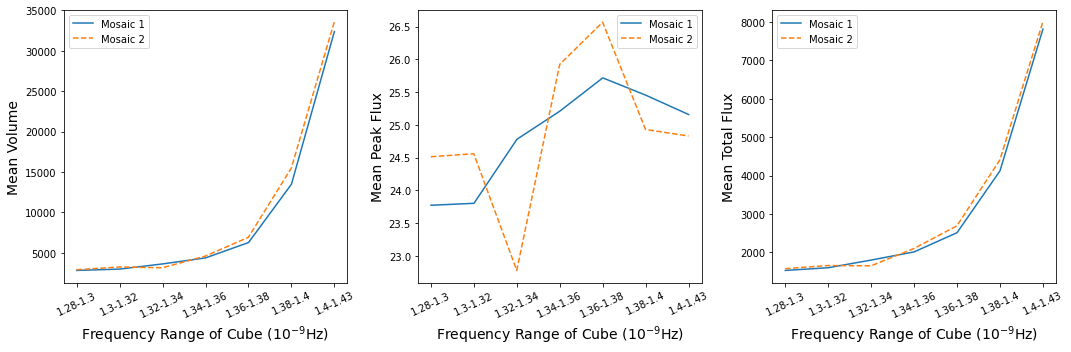

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

ax1.set_xlabel(r"Frequency Range of Cube ($10^{-9}$Hz)", fontsize=14)
ax1.set_xticks(ticks=df_1245.freq_1)
ax1.set_xticklabels(df_1245.freq_labels, rotation=25)
ax1.set_ylabel("Mean Volume", fontsize=14)
ax1.plot(df_1245.freq_1, df_1245.mean_vol, label="Mosaic 1")
ax1.plot(df_1353.freq_1, df_1353.mean_vol, label="Mosaic 2", linestyle="--")
ax1.tick_params(axis='y')
ax1.legend()

ax2.set_xlabel(r"Frequency Range of Cube ($10^{-9}$Hz)", fontsize=14)
ax2.set_xticks(ticks=df_1245.freq_1)
ax2.set_xticklabels(df_1245.freq_labels, rotation=25)
ax2.set_ylabel("Mean Peak Flux", fontsize=14)
ax2.plot(df_1245.freq_1, df_1245.mean_peak_flux, label="Mosaic 1")
ax2.plot(df_1353.freq_1, df_1353.mean_peak_flux, label="Mosaic 2", linestyle="--")
ax2.tick_params(axis='y')
ax2.legend()

ax3.set_xlabel(r"Frequency Range of Cube ($10^{-9}$Hz)", fontsize=14)
ax3.set_xticks(ticks=df_1245.freq_1)
ax3.set_xticklabels(df_1245.freq_labels, rotation=25)
ax3.set_ylabel("Mean Total Flux", fontsize=14)
ax3.plot(df_1245.freq_1, df_1245.mean_tot_flux, label="Mosaic 1")
ax3.plot(df_1353.freq_1, df_1353.mean_tot_flux, label="Mosaic 2", linestyle="--")
ax3.tick_params(axis='y')
ax3.legend()


fig.tight_layout()
plt.show()

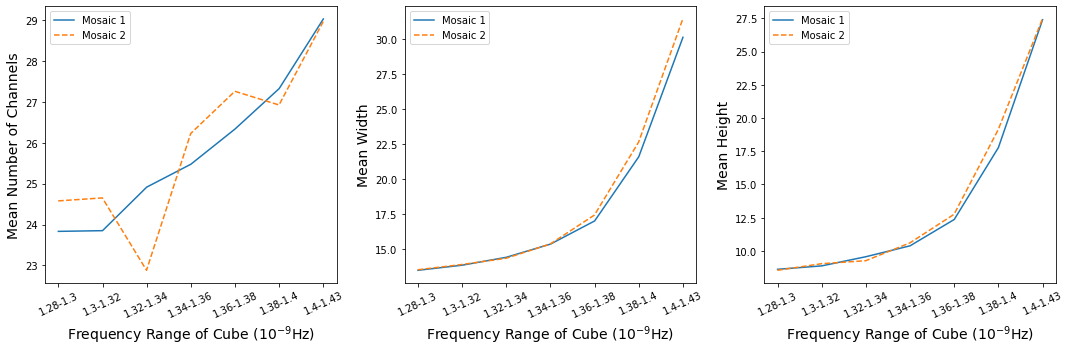

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

ax1.set_xlabel(r"Frequency Range of Cube ($10^{-9}$Hz)", fontsize=14)
ax1.set_xticks(ticks=df_1245.freq_1)
ax1.set_xticklabels(df_1245.freq_labels, rotation=25)
ax1.set_ylabel("Mean Number of Channels", fontsize=14)
ax1.plot(df_1245.freq_1, df_1245.mean_gal_dim0, label="Mosaic 1")
ax1.plot(df_1353.freq_1, df_1353.mean_gal_dim0, label="Mosaic 2", linestyle="--")
ax1.tick_params(axis='y')
ax1.legend()

ax2.set_xlabel(r"Frequency Range of Cube ($10^{-9}$Hz)", fontsize=14)
ax2.set_xticks(ticks=df_1245.freq_1)
ax2.set_xticklabels(df_1245.freq_labels, rotation=25)
ax2.set_ylabel("Mean Width", fontsize=14)
ax2.plot(df_1245.freq_1, df_1245.mean_gal_dim1, label="Mosaic 1")
ax2.plot(df_1353.freq_1, df_1353.mean_gal_dim1, label="Mosaic 2", linestyle="--")
ax2.tick_params(axis='y')
ax2.legend()

ax3.set_xlabel(r"Frequency Range of Cube ($10^{-9}$Hz)", fontsize=14)
ax3.set_xticks(ticks=df_1245.freq_1)
ax3.set_xticklabels(df_1245.freq_labels, rotation=25)
ax3.set_ylabel("Mean Height", fontsize=14)
ax3.plot(df_1245.freq_1, df_1245.mean_gal_dim2, label="Mosaic 1")
ax3.plot(df_1353.freq_1, df_1353.mean_gal_dim2, label="Mosaic 2", linestyle="--")
ax3.tick_params(axis='y')
ax3.legend()


fig.tight_layout()
plt.show()